# Shogi Notebook beta

[Debug] 後手ノーマル振り飛車
[Debug] 後手四間飛車
1筋不突き
9筋突き合い
先手は角道オープン
後手は角道クローズ
先手居飛車
後手四間飛車
先手居飛車
後手四間飛車
先手{'天守閣美濃'}
後手{'その他の囲い'}
{'天守閣美濃'}
Wall time: 9 ms


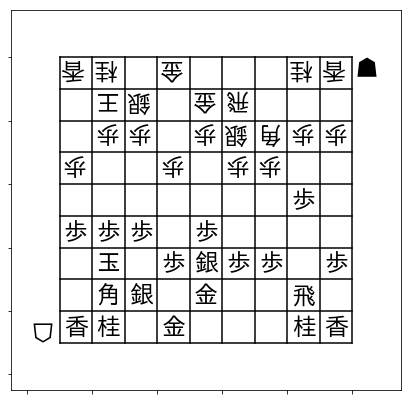

In [1]:
from Senkei import Senkei
from Kifu import Kifu

kifu = Kifu()
senkei = Senkei(True)
m = "7g7f 3c3d 3i4h 4c4d 5g5f 8b4b 5i6h 5a6b 6h7h 6b7b 4i5h 4a5b 9g9f 9c9d 8g8f 7b8b 7h8g 7a7b 7i7h 3a3b 2g2f 3b4c 2f2e 2b3c 4h5g 6c6d"
m_list = m.split(" ")

def board_test(kifu, senkei, move_list):
    for i, move in enumerate(move_list):
        m_d = kifu.move(move)
        # print(f"{a.moved}{a.move_piece_str}")
        senkei.move(m_d, i+1)
    senkei.get_large_classification()
    senkei.print()
    print(senkei.black_king_left_castle.stat_str())

%time board_test(kifu, senkei, m_list)
kifu.nowBoard.plot()

In [2]:
from Engine import Engine # エンジン実行はまだ不安定です

program_dir = "H:\\shogi\\"
temp_dir = "Z:\\temp\\"

yaselmo = {
    "name": "yaselmo",
    "cwd":  program_dir + "yaselmo\\",
    "engine_cmd": program_dir + "yaselmo\\YaneuraOu-2017-early.exe Hash 1024 Threads 6",
    "stdout": temp_dir + "yaneuraou.txt",
    "option": [
        "setoption name USI_Ponder value False",
        "setoption name Threads value 6",
        "setoption name Hash value 1024",
        "setoption name NetworkDelay value 0",
        "setoption name NetworkDelay2 value 0",
        "setoption name EvalShare value false", 
        "setoption name BookMoves value 48",
        "setoption name EvalDir value eval"
    ]
}
nanoha = {
    "name": "nanoha",
    "cwd": program_dir + "NanohaTsumeUSI170417\\",
    "engine_cmd": program_dir + "NanohaTsumeUSI170417\\NanohaTsumeUSIx64.exe",
    "stdout": temp_dir + "nanoha.txt",
    "option": []
}
yomita = {
    "name": "yomita",
    "cwd": program_dir + "yomita_WCSC27\\",
    "engine_cmd": program_dir + "yomita_WCSC27\\yomita_avx2.exe",
    "stdout": temp_dir + "yomita.txt",
    "option": [
        "setoption name USI_Ponder value False",
        "setoption name Threads value 6",
        "setoption name EvalShare value False", 
        "setoption name EvalDir value eval\\kppt_file\\WCSC27",
        "setoption name ProgressDir value progress\\1"
    ]    
}
progress = {
    "name": "yomita_for_progress",
    "cwd": program_dir + "yomita_WCSC27\\",
    "engine_cmd": program_dir + "yomita_WCSC27\\yomita_avx2.exe",
    "stdout": temp_dir + "progress.txt",
    "option": [
        "setoption name USI_Ponder value False",
        "setoption name Threads value 1",
        "setoption name Hash value 16",
        "setoption name EvalShare value False", 
        "setoption name EvalDir value eval\\kppt_file\\WCSC27",
        "setoption name ProgressDir value progress\\1"
    ]
}

In [ ]:

class BishopExchange(SenkeiPartsBase):
    """角交換を規定する"""
    def __init__(self):
        super().__init__()
        self.state = True  # 正常形かどうか
        self.update = True
        self.is_exchange = False  # 角交換したか
        self.b_captured = False  # 先手が角を捕獲した
        self.w_captured = False  # 後手が角を捕獲した
        self.b_tezon = 0
        self.w_tezon = 0
        self.comment = []

    def move(self, m_d: Move_Detail):
        if not self.update:
            return
        if m_d.type == "place":  # 駒を打ったならスルー
            return
        if self.update:
            if self.w_captured:  # 先手が後手の角を取り返しに行く
                self.update = False
                if m_d.move_piece_str == "R":  # 先手が飛を動かした
                    self.is_exchange = True
                    self.comment.append("先手向かい飛車")
                elif m_d.move_piece_str == "G":  # 先手が金を動かした
                    self.b_tezon += 1
                    self.is_exchange = True
                    if m_d.moved == (8, 8):  # 78に戻るために手損することになる
                        self.comment.append("先手一手損角換わり")
                    elif m_d.moved == (7, 7):  # 77金型(阪田流)
                        self.comment.append("先手77金型")
                    else:
                        self.state = False
                elif m_d.move_piece_str == "S":  # 先手が銀を動かした
                    self.update = False
                    self.is_exchange = True
                    if m_d.moved == (8, 8):  # 後手一手損
                        self.comment.append("一手損角換わり")
                    elif m_d.moved == (7, 7):  # 角換わり
                        self.comment.append("角換わり")
                    else:
                        self.state = False
                elif m_d.move_piece_str == "N":  # 先手が桂を動かした
                    self.update = False
                    self.is_exchange = True
                    self.comment.append("77桂")
                elif m_d.move_piece_str == "K":  # 先手が玉を動かした
                    self.update = False
                    self.is_exchange = True
                    self.comment.append("後手角交換振り飛車")
                else:  # 正常形でない
                    self.update = False
                    self.state = False

            elif self.b_captured:  # 後手が先手の角を取り返しに行く
                self.update = False
                if m_d.move_piece_str == "r":  # 後手が飛を動かした
                    self.is_exchange = True
                    self.comment.append("後手向かい飛車")
                elif m_d.move_piece_str == "g":  # 後手が金を動かした
                    self.w_tezon += 1
                    self.is_exchange = True
                    if m_d.moved == (2, 2):  # 32に戻るために手損することになる
                        self.comment.append("角換わり")
                    elif m_d.moved == (3, 3):  # 33金型(阪田流)
                        self.comment.append("後手33金型")
                    else:
                        self.state = False
                elif m_d.move_piece_str == "s":  # 後手が銀を動かした
                    self.update = False
                    self.is_exchange = True
                    if m_d.moved == (2, 2):  # 先手一手損
                        self.comment.append("先手一手損角換わり")
                    elif m_d.moved == (3, 3):  # 角換わり
                        self.comment.append("角換わり")
                    else:
                        self.state = False
                elif m_d.move_piece_str == "n":  # 後手が桂を動かした
                    self.update = False
                    self.is_exchange = True
                    self.comment.append("33桂")
                elif m_d.move_piece_str == "k":  # 後手が玉を動かした
                    self.update = False
                    self.is_exchange = True
                    self.comment.append("先手角交換振り飛車")
                else:  # 正常形でない
                    self.update = False
                    self.state = False
            elif m_d.move_piece_str == "B":  # 先手の角を動かした
                if m_d.moved != (7, 7) or  m_d.moved != (3, 3) or  m_d.moved != (2, 2):  # 77、33、22以外に動くと通常形でない
                    self.state = False
                    self.update = False
                else:
                    self.b_tezon += 1
                    if m_d.get_piece_origin_str == "b":  # 後手の角を捕獲した
                        self.b_captured = True
            elif m_d.move_piece_str == "b":  # 後手の角を動かした
                if m_d.moved != (3, 3) or  m_d.moved != (7, 7) or  m_d.moved != (8, 8):  # 33、77、88以外に動くと通常形でない
                    self.state = False
                    self.update = False
                else:
                    self.w_tezon += 1
                    if m_d.get_piece_origin_str == "B":  # 先手の角を捕獲した
                        self.w_captured = True

    def stat_str(self) -> List[str]:
        if not self.state:
            return ["角交換の通常形でない"]
        tezon = self.b_tezon - self.w_tezon
        result = []
        result.append(self.comment)
        return result




In [3]:
from Kifu import Kifu
from Kifu import battle

Yane = Engine(yaselmo, False)
Yane.init_engine()
Yane.usinewgame()

Yomita = Engine(yomita, False)
Yomita.init_engine()
Yomita.usinewgame()

Progress = Engine(progress, False)
Progress.init_engine()
Progress.usinewgame()

kifu_option_test = {
    "title": "対局テスト",
    "black_name": Yane.local_name,
    "white_name": Yomita.local_name,
    "teai": "平手",
    "comment": "コメント",
    "debug": "デバッグ情報"
}

kifu = Kifu(kifu_option=kifu_option_test)
battle(Yane, Yomita, kifu, Progress)

Yane.quit()
Yomita.quit()
Progress.quit()

ID:「yaselmo」
USIコマンド： OK
READY： OK
ID:「Yomita_kppt_file4.0」
USIコマンド： OK
READY： OK
ID:「Yomita_kppt_file4.0」
USIコマンド： OK
READY： OK
bestmove: 2g2f 106
bestmove: 3c3d
bestmove: 7g7f 73
bestmove: 8c8d
bestmove: 2f2e 110
bestmove: 8d8e
bestmove: 5i5h 56
bestmove: 8e8f
bestmove: 8g8f 131
bestmove: 8b8f
bestmove: 8h2b+ 317
bestmove: 3a2b
bestmove: B*7g 283
bestmove: 8f8b
bestmove: P*8c 183
bestmove: 8b4b
bestmove: 2e2d 374
bestmove: 2c2d
bestmove: 2h2d 297
bestmove: 4c4d
bestmove: 7i7h 345
bestmove: 6a7b
bestmove: 7g4d 417
bestmove: P*2c 347
bestmove: 2d3d -261
bestmove: P*3c 622
bestmove: 4d5c+ -728
bestmove: 3c3d 776
bestmove: 8i7g -820
bestmove: B*2g 865
bestmove: 7g6e -880
bestmove: 4b4g+ 934
bestmove: 5h4g -1166
bestmove: 2g4i+ 1136
bestmove: R*5i -1061
bestmove: P*4f 1156
bestmove: 4g4f -1175
bestmove: 4i5i 1165
bestmove: 6i5i -1088
bestmove: R*7i 1148
bestmove: P*4b -1031
bestmove: 4a4b 1506
bestmove: 5i6i -1681
bestmove: 7i9i+ 1657
bestmove: 4f4g -1571
bestmove: R*4e 1698
bestmove: P*4

☗yaselmo VS ☖yomita
手合い： 平手
後手の勝ちです
勝った方の最小の評価値は0
負けた方の最大の評価値は417
手数は82
先手玉の重心は(3.9166666666666665, 7.583333333333333)
先手玉の最頻値は(5, 8)
後手玉の重心は(5.0, 1.0)
後手玉の最頻値は(5, 1)
先手飛の重心は(2.1200000000000001, 6.7199999999999998)
先手飛の最頻値は(2, 8)
後手飛の重心は(6.0, 2.6071428571428572)
後手飛の最頻値は(4, 2)
先手の成りの回数は2
後手の成りの回数は5


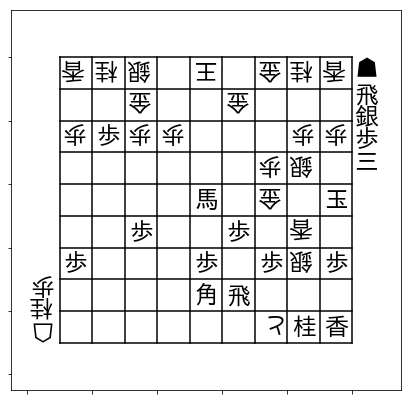

棋譜：position sfen lnsgkgsnl/1r5b1/ppppppppp/9/9/9/PPPPPPPPP/1B5R1/LNSGKGSNL b - 1 moves 2g2f 3c3d 7g7f 8c8d 2f2e 8d8e 5i5h 8e8f 8g8f 8b8f 8h2b+ 3a2b B*7g 8f8b P*8c 8b4b 2e2d 2c2d 2h2d 4c4d 7i7h 6a7b 7g4d P*2c 2d3d P*3c 4d5c+ 3c3d 8i7g B*2g 7g6e 4b4g+ 5h4g 2g4i+ R*5i P*4f 4g4f 4i5i 6i5i R*7i P*4b 4a4b 5i6i 7i9i+ 4f4g R*4e P*4f 4e6e 5c4d N*5e 4g3h 2b3c 4d5d 6e6g+ 5d5e 6g6i 7h6i 9i6i B*3f S*2g 3f2g 6i5h N*4h P*4g R*3a G*4a 2g3f 4g4h+ 3h2g 4a3a 3f5h 4h3i R*4h R*2f 2g2f G*3e 2f2g L*2f 2g1f S*2g 1f1e 3c2d
動かした駒の統計：OrderedDict([('K', 10), ('R', 2), ('B', 6), ('G', 2), ('S', 2), ('N', 2), ('L', 0), ('P', 5), ('+R', 0), ('+B', 3), ('+S', 0), ('+N', 0), ('+L', 0), ('+P', 0), ('*_b', 9), ('k', 0), ('r', 7), ('b', 1), ('g', 3), ('s', 3), ('n', 0), ('l', 0), ('p', 8), ('+r', 3), ('+b', 1), ('+s', 0), ('+n', 0), ('+l', 0), ('+p', 1), ('*_w', 14)])


In [4]:
kifu.print_kifu_option()
kifu.stat()
kifu.nowBoard.plot()
print(f"棋譜：{kifu.get_sfen()}")
print(f"動かした駒の統計：{kifu.stat_move}")

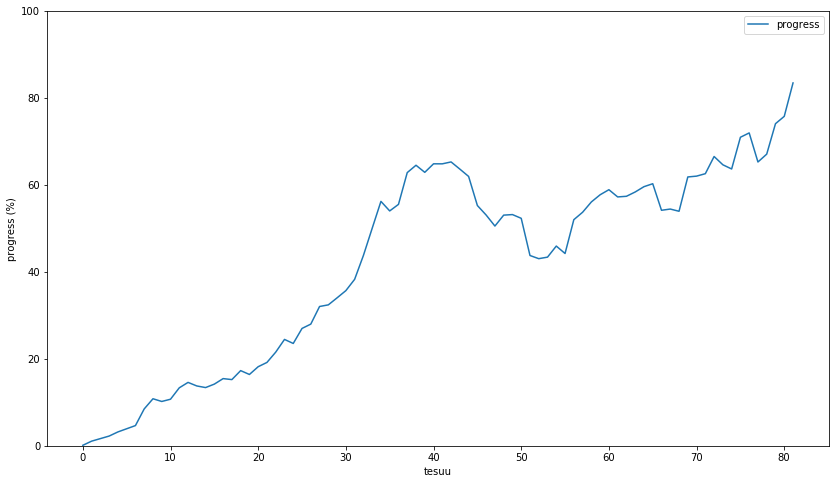

In [5]:
%matplotlib inline
kifu.plot_prog() # 進行度の推移をプロットします。

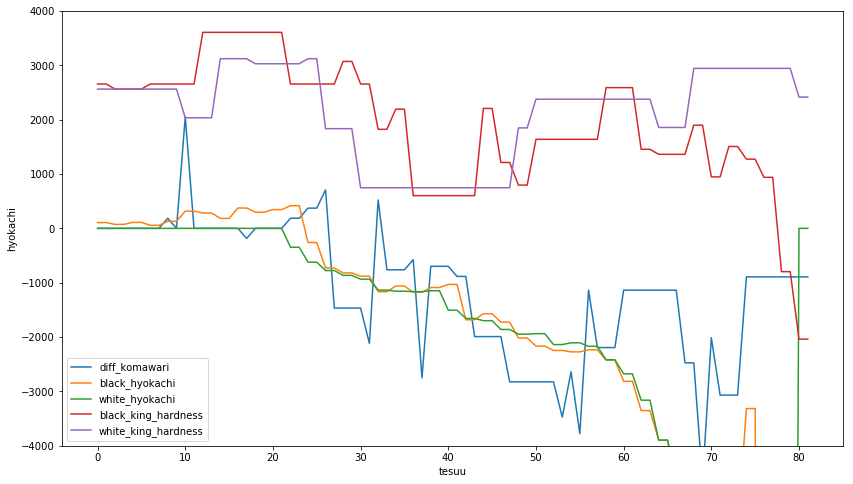

In [6]:
kifu.plot_score() # 評価値と駒割りの推移をプロットします。

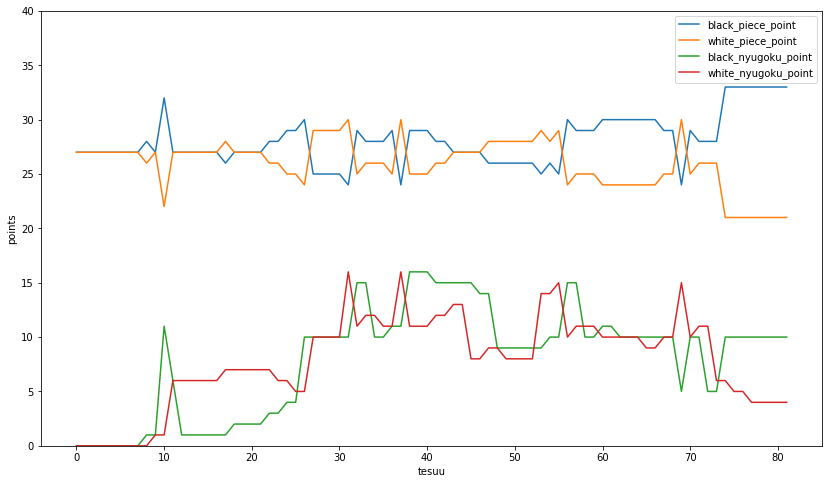

In [7]:
kifu.plot_point() # 駒点数の推移をプロットします。

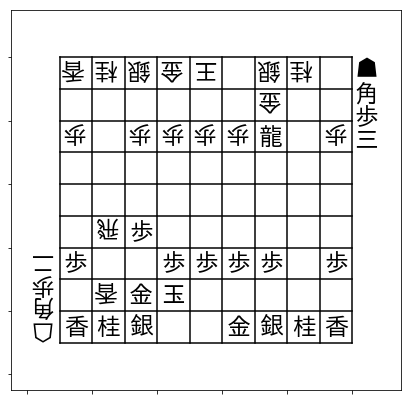

[(3, 3)]

In [5]:
# 駒を移動させるサンプル
from Board import Board
from subject import subject
from Bitboard import B_BLACK, B_WHITE
A = Board(subject['横歩取り']['33角']['勇気'])
A.move("1a8h")
A.move("3d3c+")
A.move("2a3c")
A.plot()
A.count_b_bitboard(B_BLACK) # 先手陣の駒は15枚
A.get_x_pos2("+R")

sfen lnsgk1snl/6g2/p1ppppb1p/6R2/9/1rP6/P2PPPP1P/1BGK5/LNS2GSNL w 3P2p 18


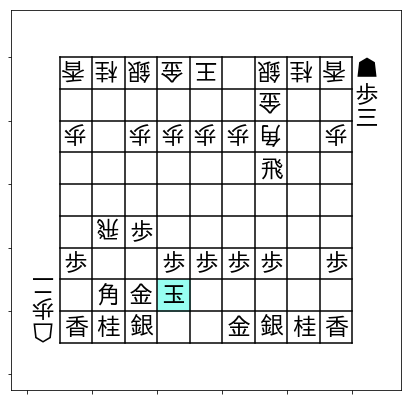

In [5]:
Yuuki = Board(subject['横歩取り']['33角']['勇気'])
print(Yuuki.get_sfen())
Yuuki.plot((6, 8))

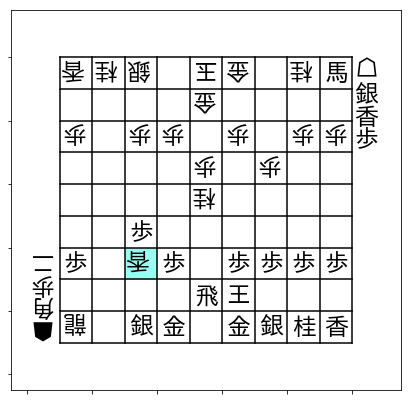

In [8]:
Board(subject['ゴキゲン中飛車']['超急戦']['都成']).plot123((3, 3))